In [1]:
# Install required packages
!pip install tensorflow keras matplotlib seaborn scikit-learn opencv-python -q

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.28.0 requires protobuf<5,>=3.20, but you have protobuf 6.33.0 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

print('TensorFlow version:', tf.__version__)
print('GPU Available:', len(tf.config.list_physical_devices('GPU')) > 0)

TensorFlow version: 2.20.0
GPU Available: False


In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 1e-4

In [5]:
def create_synthetic_melanoma_data(num_samples=1000):
    print(f'Creating {num_samples} synthetic dermoscopic images...')
    images = []
    labels = []
    
    for i in range(num_samples):
        img = np.random.rand(IMAGE_SIZE, IMAGE_SIZE, 3) * 0.3 + 0.4
        center_x, center_y = IMAGE_SIZE // 2, IMAGE_SIZE // 2
        
        if i < num_samples // 2:
            radius = np.random.randint(30, 50)
            color = np.array([0.3, 0.2, 0.1]) * np.random.uniform(0.8, 1.2)
            cv2.circle(img, (center_x, center_y), radius, color.tolist(), -1)
            labels.append(0)
        else:
            for _ in range(3):
                offset_x = np.random.randint(-20, 20)
                offset_y = np.random.randint(-20, 20)
                radius = np.random.randint(25, 45)
                color = np.random.rand(3) * 0.3
                cv2.circle(img, (center_x + offset_x, center_y + offset_y), radius, color.tolist(), -1)
            labels.append(1)
        
        noise = np.random.randn(IMAGE_SIZE, IMAGE_SIZE, 3) * 0.05
        img = np.clip(img + noise, 0, 1)
        images.append(img)
    
    return np.array(images, dtype=np.float32), np.array(labels)

In [6]:
X, y = create_synthetic_melanoma_data(num_samples=1000)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f'Training: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}')
print(f'Train - Benign: {np.sum(y_train==0)}, Malignant: {np.sum(y_train==1)}')

Creating 1000 synthetic dermoscopic images...
Training: 700, Validation: 150, Test: 150
Train - Benign: 350, Malignant: 350


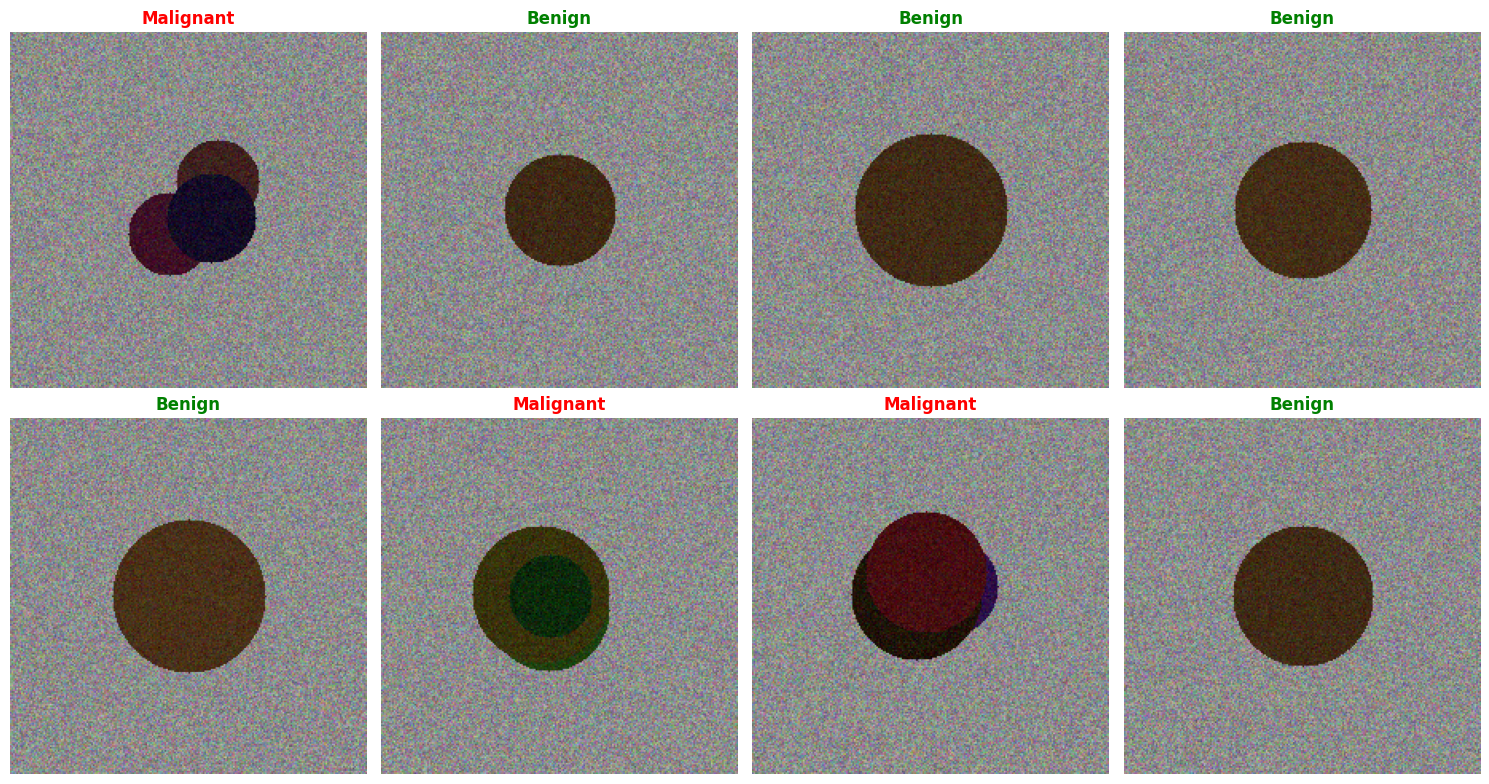

In [7]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()
indices = np.random.choice(len(X_train), 8, replace=False)
label_names = ['Benign', 'Malignant']

for i, idx in enumerate(indices):
    axes[i].imshow(X_train[idx])
    color = 'green' if y_train[idx] == 0 else 'red'
    axes[i].set_title(label_names[y_train[idx]], color=color, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [8]:
def build_melanoma_classifier():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

model = build_melanoma_classifier()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 323,105 (1.23 MB)

 Trainable params: 321,697 (1.23 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [9]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc'), keras.metrics.Precision(), keras.metrics.Recall()]
)

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('best_melanoma_model.h5', monitor='val_auc', mode='max', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_auc', mode='max', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)

In [11]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8288 - auc: 0.9135 - loss: 0.3373 - precision: 0.8674 - recall: 0.7754
Epoch 1: val_auc improved from None to 0.50000, saving model to best_melanoma_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9114 - auc: 0.9777 - loss: 0.2021 - precision: 0.9472 - recall: 0.8714 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.7076 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9545 - auc: 0.9905 - loss: 0.1269 - precision: 0.9921 - recall: 0.9177
Epoch 2: val_auc did not improve from 0.50000
22/22 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9600 - auc: 0.9939 - loss: 0.1052 - precision: 0.9879 - recall: 0.9314 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.7514 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9620 - auc: 0.9971 - loss: 0.0951 - precision: 0.9921 - recall: 0.9333
Epoch 3: val_auc improved from 0.50000 to 0.89333, saving model to best_melanoma_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9714 - auc: 0.9973 - loss: 0.0781 - precision: 0.9882 - recall: 0.9543 - val_accuracy: 0.5000 - val_auc: 0.8933 - val_loss: 0.8280 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9750 - auc: 0.9982 - loss: 0.0726 - precision: 0.9957 - recall: 0.9553
Epoch 4: val_auc did not improve from 0.89333
22/22 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9786 - auc: 0.9984 - loss: 0.0615 - precision: 0.9912 - recall: 0.9657 - val_accuracy: 0.5000 - val_auc: 0.6200 - val_loss: 0.9338 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9790 - auc: 0.9986 - loss: 0.0609 - precision: 0.9956 - recall: 0.9633
Epoch 5: val_auc did not improve from 0.89333
22/22 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9843 - auc: 0.9992 - loss: 0.0461 - precision: 0.9942 - r

22/22 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9843 - auc: 0.9993 - loss: 0.0392 - precision: 0.9942 - recall: 0.9743 - val_accuracy: 0.5000 - val_auc: 0.9000 - val_loss: 1.2445 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-05
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9897 - auc: 0.9999 - loss: 0.0317 - precision: 1.0000 - recall: 0.9799
Epoch 8: val_auc did not improve from 0.90000
22/22 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9914 - auc: 0.9999 - loss: 0.0290 - precision: 1.0000 - recall: 0.9829 - val_accuracy: 0.5000 - val_auc: 0.8400 - val_loss: 1.2984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-05
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9805 - auc: 0.9998 - loss: 0.0359 - precision: 0.9956 - recall: 0.9663
Epoch 9: val_auc did not improve from 0.90000
22/22 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9871 - auc: 0.9997 - loss: 0.0286 - precision: 0.9942 - r


Epoch 11: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
22/22 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.9886 - auc: 0.9997 - loss: 0.0284 - precision: 0.9971 - recall: 0.9800 - val_accuracy: 0.5000 - val_auc: 0.9002 - val_loss: 0.9408 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-05
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9895 - auc: 1.0000 - loss: 0.0282 - precision: 1.0000 - recall: 0.9796
Epoch 12: val_auc improved from 0.90018 to 0.90080, saving model to best_melanoma_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.9943 - auc: 1.0000 - loss: 0.0234 - precision: 1.0000 - recall: 0.9886 - val_accuracy: 0.5000 - val_auc: 0.9008 - val_loss: 0.7932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.5000e-05
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9901 - auc: 0.9997 - loss: 0.0300 - precision: 0.9978 - recall: 0.9829
Epoch 13: val_auc did not improve from 0.90080
22/22 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.9929 - auc: 0.9997 - loss: 0.0244 - precision: 0.9971 - recall: 0.9886 - val_accuracy: 0.5000 - val_auc: 0.8628 - val_loss: 0.7434 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.5000e-05
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9873 - auc: 0.9998 - loss: 0.0298 - precision: 0.9924 - recall: 0.9828
Epoch 14: val_auc did not improve from 0.90080
22/22 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.9929 - auc: 0.9999 - loss: 0.0230 - precision: 0.9971

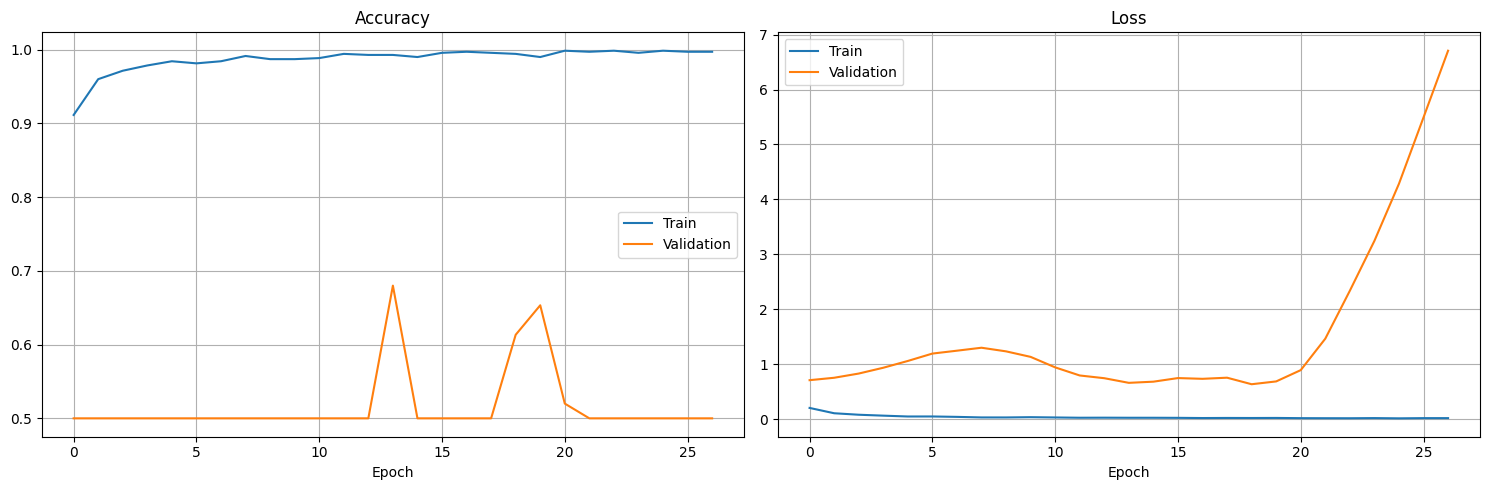

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history['accuracy'], label='Train')
axes[0].plot(history.history['val_accuracy'], label='Validation')
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history.history['loss'], label='Train')
axes[1].plot(history.history['val_loss'], label='Validation')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [13]:
y_pred_proba = model.predict(X_test).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

test_results = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_results[0]:.4f}')
print(f'Test Accuracy: {test_results[1]:.4f}')
print(f'Test AUC: {test_results[2]:.4f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 680ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step - accuracy: 0.5000 - auc: 0.8894 - loss: 0.7953 - precision: 0.0000e+00 - recall: 0.0000e+00
Test Loss: 0.7953
Test Accuracy: 0.5000
Test AUC: 0.8894


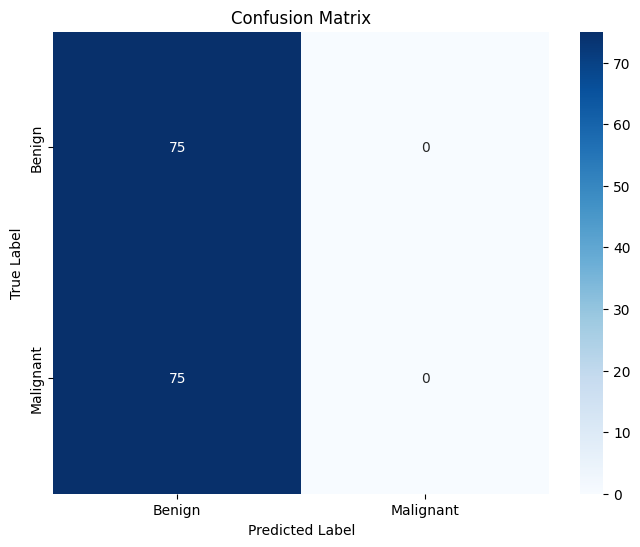

In [14]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

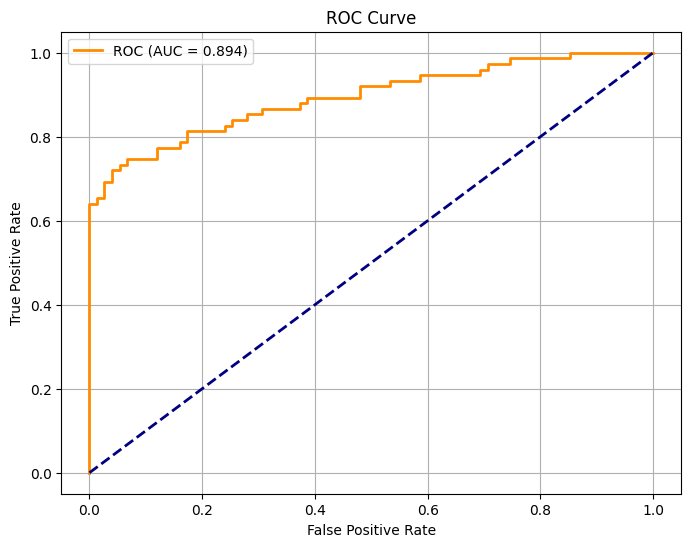

In [15]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malignant']))

              precision    recall  f1-score   support

      Benign       0.50      1.00      0.67        75
   Malignant       0.00      0.00      0.00        75

    accuracy                           0.50       150
   macro avg       0.25      0.50      0.33       150
weighted avg       0.25      0.50      0.33       150



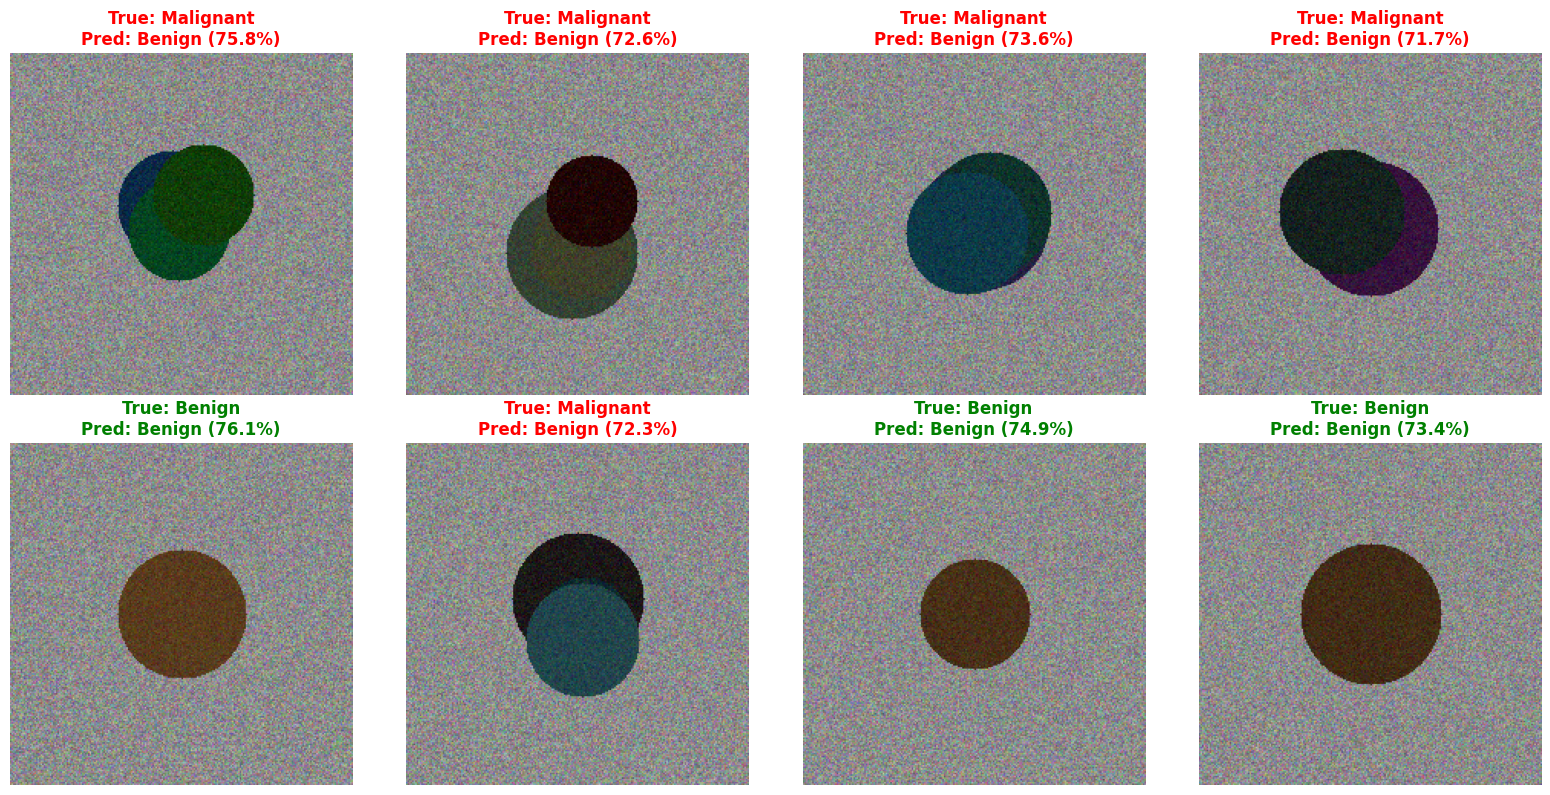

In [17]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
indices = np.random.choice(len(X_test), 8, replace=False)
label_names = ['Benign', 'Malignant']

for i, idx in enumerate(indices):
    axes[i].imshow(X_test[idx])
    true_label = label_names[y_test[idx]]
    pred_label = label_names[y_pred[idx]]
    confidence = y_pred_proba[idx] if y_pred[idx]==1 else (1-y_pred_proba[idx])
    color = 'green' if y_test[idx]==y_pred[idx] else 'red'
    axes[i].set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1%})', color=color, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.show()